Load required Julia packages

In [1]:
using Plots; pyplot();
using ArraysOfArrays, StaticArrays, Tables, TypedTables
using Statistics, Random, Distributions, StatsBase
using Unitful

using SolidStateDetectors

T = Float32

# Note: it is typical to include all the packages used in the code
# at the top of the code. However, I added some "using ..." lines
# down in the code, as a way of remembering which package is used for what

Float32

### Input/Output package -> read saved simulation

The package offeres a conversion of all the calculated fields to `NamedTuple`'s which allows for saving and loading them into HDF5 files via the LegendHDF5 package

┌ Info: I/O of charge drift model not yet supported. Loading default: ADLChargeDriftModel
└ @ SolidStateDetectors C:\Users\Mohamed Emam\.julia\packages\SolidStateDetectors\48ipd\src\Simulation\Simulation.jl:92


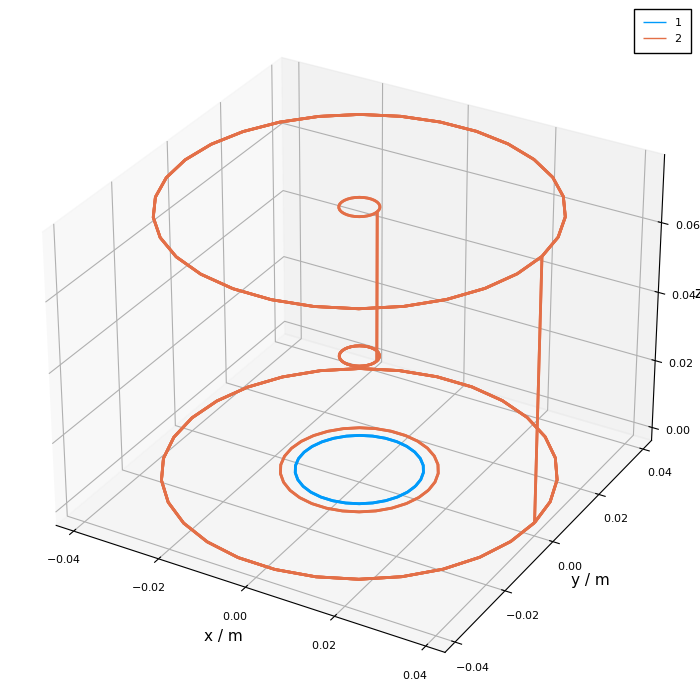

In [2]:
using LegendHDF5IO: readdata, writedata
import HDF5

filename = "cache/HADES_simulation.h5f"
simulation = SolidStateDetectors.ssd_read(filename, Simulation)

plot(simulation.detector, size = (700, 700))

Now no need to apply all the previous calculations (e.g. electric field, drift fields, ...), since they are already saved in the file reconfirm this by running weighting potential plot (or any other plots from part 1 here)

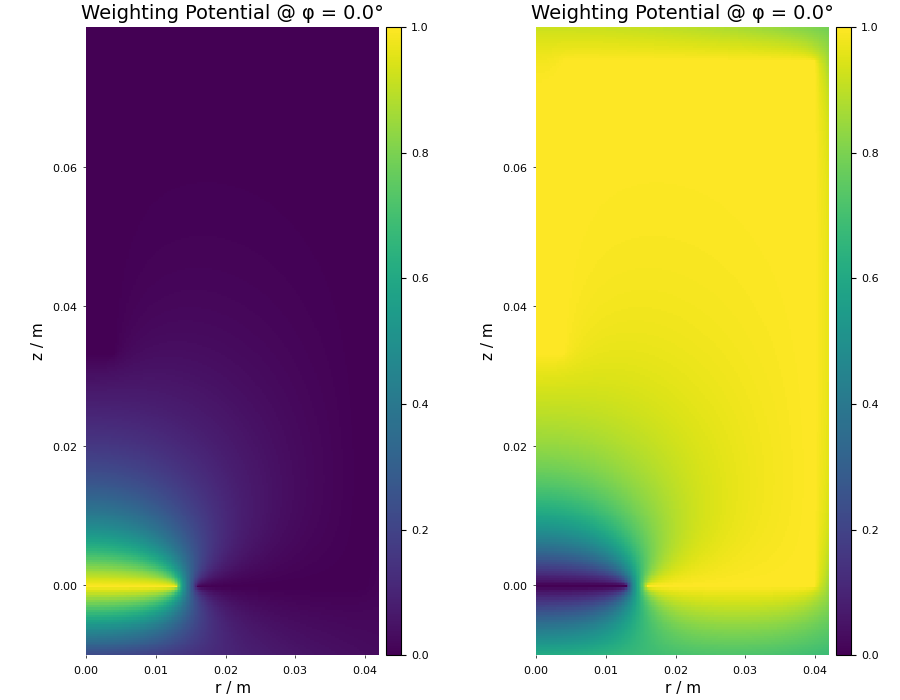

In [3]:
plot(
    plot(simulation.weighting_potentials[1]),
    plot(simulation.weighting_potentials[2]),
    size = (900, 700)
)

Waveform generation for Geant4 MC events

In [4]:
using LegendTextIO # Geant4CSVInput

Let's read in some Monte-Carlo events (produced by Geant4). We'll either read from Geant4 CSV and cache the result as HDF5, or read directly from HDF5 if already available

In [5]:
mctruth_filename_csv = "data/d2.csv"
mctruth_filename_hdf5 = "cache/raw-IC160A-Th228-uncollimated-top-run0002-source_holder-bi-hdf5-02.h5"

if isfile(mctruth_filename_hdf5)
    println("Reading MC events from HDF5.")
    mc_events = HDF5.h5open(mctruth_filename_hdf5, "r") do input
        readdata(input, "mctruth")
    end
else
    println("Reading MC events from Geant4-CSV.")
    mc_events = open(read, mctruth_filename_csv, Geant4CSVInput)
    mkpath(dirname(mctruth_filename_hdf5))
    println("Writing MC events to HDF5.")
    HDF5.h5open(mctruth_filename_hdf5, "w") do output
        writedata(output, "mctruth", mc_events)
    end
end

mc_events.evtno

Reading MC events from HDF5.


87068-element Array{Int32,1}:
       2
      48
     295
     322
     484
     566
     821
    1031
    1078
    1447
    1530
    1725
    1892
       ⋮
 9998780
 9998900
 9998909
 9998933
 9999032
 9999087
 9999221
 9999611
 9999896
 9999924
 9999983
 9999991

Producing pulse shapes from raw MC events is wastful, it's more efficient to cluster detectors hits (within a small radius) first

In [6]:
using RadiationDetectorSignals
using LegendDataTypes

2767819 hits before clustering
 23.311632 seconds (84.82 M allocations: 5.791 GiB, 7.56% gc time)
2766958 hits after clustering


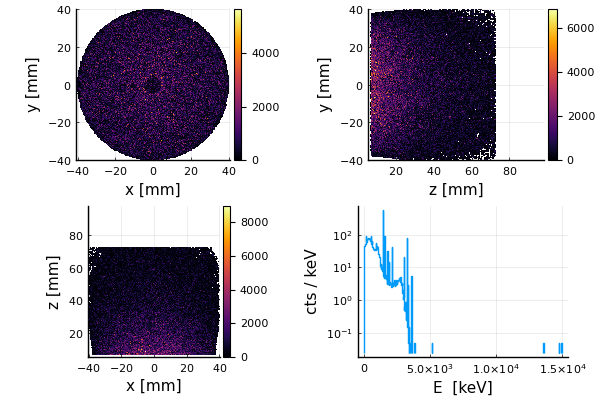

sys:1: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
sys:1: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.


In [9]:
println("$(sum(length.(mc_events.edep))) hits before clustering")
mc_events_clustered = @time SolidStateDetectors.cluster_detector_hits(mc_events, 0.0u"mm")
println("$(sum(length.(mc_events_clustered.edep))) hits after clustering")
typeof(mc_events_clustered) <: DetectorHitEvents 
plot(mc_events_clustered)

Waveform generation has to be per detector. Let's reshuffle the detector hits, grouping by event number and detector

In [10]:
using RadiationDetectorSignals: group_by_evtno, ungroup_by_evtno, group_by_evtno_and_detno

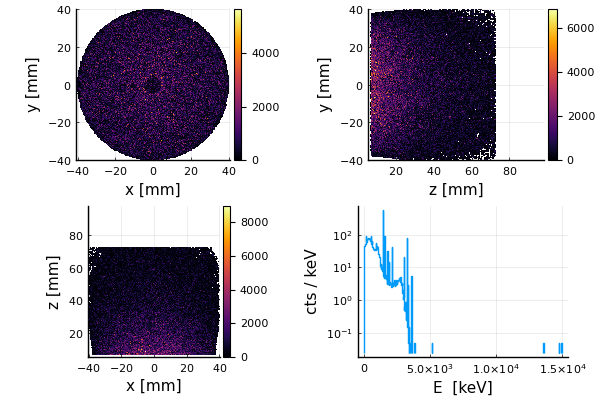

sys:1: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
sys:1: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.


In [11]:
hits = ungroup_by_evtno(mc_events_clustered)
mc_events_per_det = group_by_evtno_and_detno(hits)

# The hits are now grouped by event number, but separately for each detector, and sorted by detector number:
issorted(mc_events_per_det.detno)

#This makes it easy to group them by detector number ...
mc_events_by_det = Table(consgroupedview(mc_events_per_det.detno, Tables.columns(mc_events_per_det)))
#... and get all events for detector 1 in one chunk:
mc_events_det1 = Table(mc_events_by_det[1]) #M/ detector number 1, in this example we use two detectors 
plot(mc_events_det1)

#M/ A view of single detector

Raw MC events have a very narrow line width

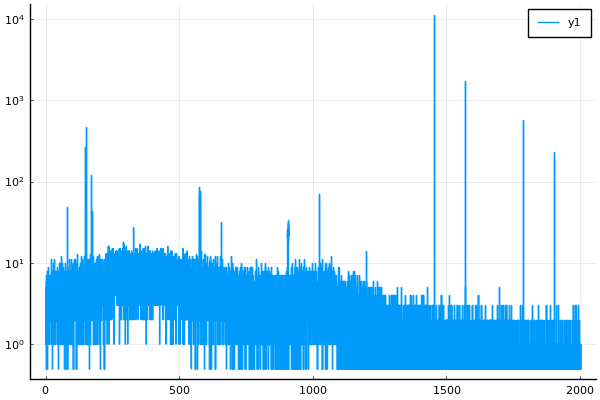

sys:1: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
sys:1: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.


In [12]:
stephist(ustrip(sum.(mc_events_det1.edep)), bins = 0:0.1:2000, yscale = :log10)

#M/ command ustrip ???

Let's make things more realistic by adding Fano noise:

In [13]:
#M/ Fano noise is a fluctuation of an electric charge obtained in a detector
#M/ edep = energy deposit

Random.seed!(123) # only for testing
det_material = simulation.detector.semiconductors[1].material
mc_events_fnoise = add_fano_noise(mc_events_det1, det_material.E_ionisation, det_material.f_fano)
stephist(ustrip.(sum.(mc_events_det1.edep)), bins = 200:0.1:1000, label = "raw MC edep", yscale = :log10)
stephist!(ustrip.(sum.(mc_events_fnoise.edep)), bins = 200:0.1:1000, label = "with Fano noise", yscale = :log10)

sys:1: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
sys:1: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.


Also, we need to filter out the few events that, due to numerical effects, lie outside of the detector (the proper solution is to shift them slightly, this feature will be added in the future)

In [14]:
filtered_events = mc_events_fnoise[findall(pts -> all(p -> T.(ustrip.(uconvert.(u"m", p)))
                in simulation.detector, pts), mc_events_fnoise.pos)];
length(filtered_events)

contact_charge_signals = SolidStateDetectors.simulate_waveforms(
        filtered_events[1:2000],
        simulation,
        max_nsteps = 4000,
        Δt = 1u"ns",
        verbose = false);

# Let's plot the first 100 generated waveforms:
waveforms = ArrayOfRDWaveforms(contact_charge_signals.waveform)
plot(waveforms[1:100], legend = false)

┌ Info: Detector has 2 contact(s)
└ @ SolidStateDetectors C:\Users\Mohamed Emam\.julia\packages\SolidStateDetectors\48ipd\src\MCEventsProcessing\MCEventsProcessing.jl:18
┌ Info: Table has 2000 physics events (63583 single charge depositions).
└ @ SolidStateDetectors C:\Users\Mohamed Emam\.julia\packages\SolidStateDetectors\48ipd\src\MCEventsProcessing\MCEventsProcessing.jl:19
Progress: 100%|█████████████████████████████████████████| Time: 0:02:10
┌ Info: Generating waveforms...
└ @ SolidStateDetectors C:\Users\Mohamed Emam\.julia\packages\SolidStateDetectors\48ipd\src\MCEventsProcessing\MCEventsProcessing.jl:24


### Differentiate to get current

This part is added by Mariia. This is a simplistic way of doing it, and the real procedure is probably more complex

In [15]:
idxmax = 10
# for some reason doesn't want to plot with units
tmc = Unitful.ustrip(waveforms[1].time[1:end-1])
vdmc = []

for idx in 1:idxmax
    push!(vdmc,diff(waveforms[idx].value))
end

plot(tmc, vdmc, lw = 1.5, xlims = (0, 4000), xlabel = "Time [ns]",
        ylabel = "", legend=false, tickfontsize = 12, guidefontsize = 14)


LoadError: Expects 522 elements in each col of y, found 3999.

Plot charge and current together

In [16]:
idxmax = 10
plot(
    plot(waveforms[1:idxmax], legend = false),
    plot(tmc, vdmc[1:idxmax], lw = 1.5, xlims = (0, 4000), xlabel = "Time [ns]", ylabel = "",
                    legend=false, tickfontsize = 12, guidefontsize = 14),
    layout = (2, 1), size = (1400, 700)
)

LoadError: Expects 522 elements in each col of y, found 3999.

One can also look individual events

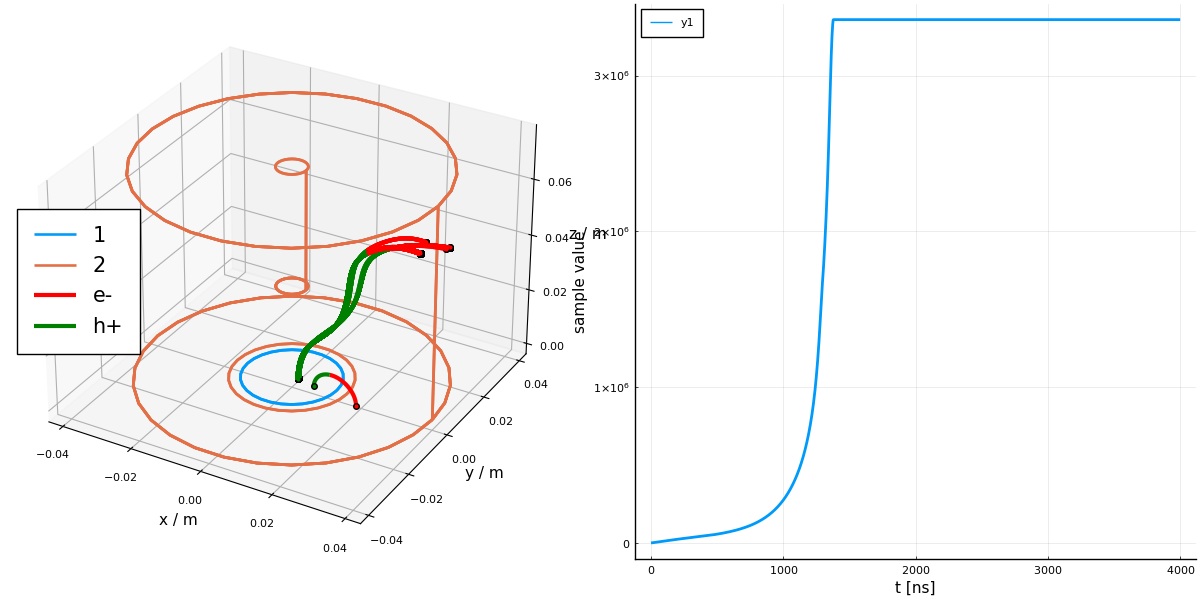

In [17]:
idx = 4 #event number
evt1 = Event(filtered_events[idx], T)

simulate!(evt1, simulation, max_nsteps = 4000, Δt = 1u"ns", verbose = true)

p_drift = plot(simulation.detector)
plot!(evt1.drift_paths)
p_signal = plot(evt1.waveforms[1], lw = 2)
plot(p_drift, p_signal, size = (1200, 600))

We should add pre- and post-pulse baselines ...

In [18]:
waveforms_with_baseline_and_tail = ArrayOfRDWaveforms(SolidStateDetectors.add_baseline_and_extend_tail.(waveforms, 1200, 7000));
plot(waveforms_with_baseline_and_tail[1:10], legend = false)

#... and also add some random values along the waveforms to simulate electronics noise in a simple fashion:

noise = map( wf -> rand!(Normal(0, 5e3), similar(wf)), waveforms_with_baseline_and_tail.value)
noisy_waveforms = ArrayOfRDWaveforms(
    map(
        wf -> RDWaveform(wf.time, wf.value .+ rand!(Normal(0, 5e3), similar(wf.value))),
        waveforms_with_baseline_and_tail
    )
)
plot(noisy_waveforms[1:100], legend = false, size = (900, 400))

### Waveform DSP (Digital Signal Processing)

Note: This section only demonstrates a very simple form of DSP for energy reconstruction, and will be extended in the near future. We can reconstruct a spectrum from the simulated waveforms, using the difference between the pre- and post-pulse baseline means energy of the events (equivalent to a triangular shaping filter in a fixed position)

In [19]:
filter_length = 50
pre_pulse_mean = mean.(map(signal -> signal[1:filter_length], noisy_waveforms.value))
pre_pulse_std = std.(map(signal -> signal[1:filter_length], noisy_waveforms.value))
energy_threshold = mean(pre_pulse_std) * 3
post_pulse_mean = mean.(map(signal -> signal[end-filter_length:end], noisy_waveforms.value))
E_reco = post_pulse_mean .- pre_pulse_mean
hist_uncal = fit(Histogram, filter(e -> e > energy_threshold, E_reco), nbins = 2000)
plot(hist_uncal, st = :step, yscale = :log10, label="uncalibrated spectrum")

sys:1: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
sys:1: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.


### Spectrum analysis

The package RadiationSpectra.jl provides a mechanism finding peaks in the spectrum. It can also auto-calibration of the spectrum, given a list of gamma lines that may be in the spectrum

[576.9097920384598, 1454.893289934079, 1570.8341693958282, 3241.0447335942513]


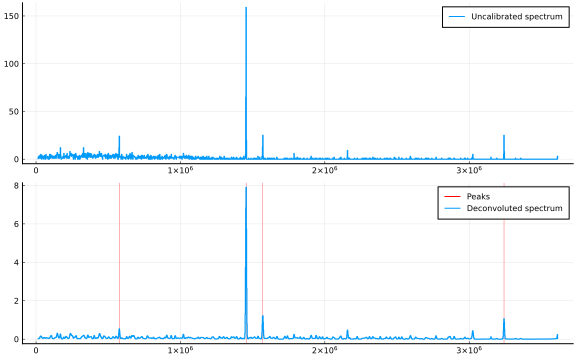

In [56]:
using RadiationSpectra
h_decon, peakpos = RadiationSpectra.peakfinder(hist_uncal)
using Plots
p_uncal = plot(hist_uncal, st=:step, label="Uncalibrated spectrum", c=1, lw=1.2);
p_decon = plot(peakpos, st=:vline, c=:red, label="Peaks", lw=0.3);
plot!(h_decon, st=:step, label="Deconvoluted spectrum", c=1, lw=1.2);
plot(p_uncal, p_decon, size=(800,500), layout=(2, 1), fmt=:svg)


[576.9097920384598, 1454.893289934079, 1570.8341693958282, 3241.0447335942513]


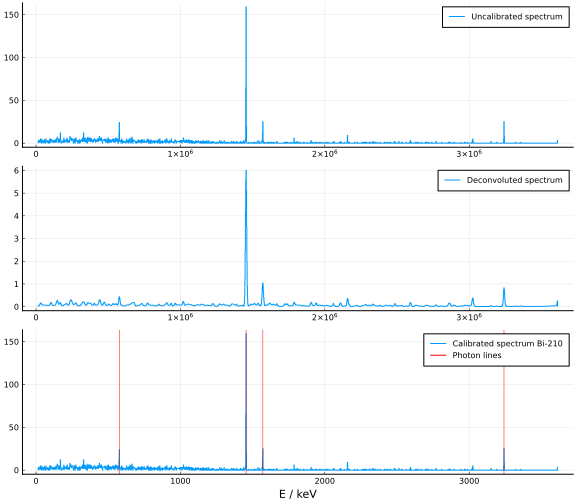

In [58]:
using Plots, RadiationSpectra

photon_lines = sort(peakpos/1e3) # keV
h_cal, h_deconv, peakPositions, threshold, c, c_precal = RadiationSpectra.calibrate_spectrum(hist_uncal, photon_lines)
println(sort(peakpos)/1e3) #kev

p_uncal = plot(hist_uncal, st=:step, label="Uncalibrated spectrum");
p_deconv = plot(h_deconv, st=:step, label = "Deconvoluted spectrum");
#hline!([threshold], label = "threshold", lw = 1.5);
p_cal = plot(h_cal, st=:step, label="Calibrated spectrum Bi-210", xlabel="E / keV");
vline!(photon_lines, lw=0.5, color=:red, label="Photon lines");
plot(p_uncal, p_deconv, p_cal, size=(800,700), layout=(3, 1), fmt=:svg)